In [1]:
import render_optimized as render #################à
import rooms.dataset
import evaluate
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import metrics

import timeit

/home/gzanin/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
torch.set_default_dtype(torch.float32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
D_0 = rooms.dataset.dataLoader("classroomBase")

In [4]:
L_0 = render.get_listener(source_xyz=D_0.speaker_xyz, listener_xyz = D_0.xyzs[0], surfaces=D_0.all_surfaces, 
                                                speed_of_sound=D_0.speed_of_sound,
                                                parallel_surface_pairs=D_0.parallel_surface_pairs,
                                                max_order=D_0.max_order, max_axial_order=D_0.max_axial_order)

Considered Paths:	59050
Total Considered Paths, after Axial:	59080
Valid Paths:	851


In [5]:
R_0 = render.Renderer(n_surfaces=len(D_0.all_surfaces))

In [6]:
# Use many GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    R_0 = nn.DataParallel(R_0).module

In [7]:
pt_file = torch.load('./models/classroomBase/weights.pt', map_location=device)
R_0.energy_vector = nn.Parameter(pt_file['model_state_dict']['energy_vector'])
R_0.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R_0.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R_0.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R_0.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R_0.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

R_0.bp_ord_cut_freqs.to(device) 

Parameter containing:
tensor([  70.,  400.,  800., 1000., 1300., 2000.], requires_grad=True)

[1.         1.         1.         ... 0.71430946 0.71430946 0.71430946]


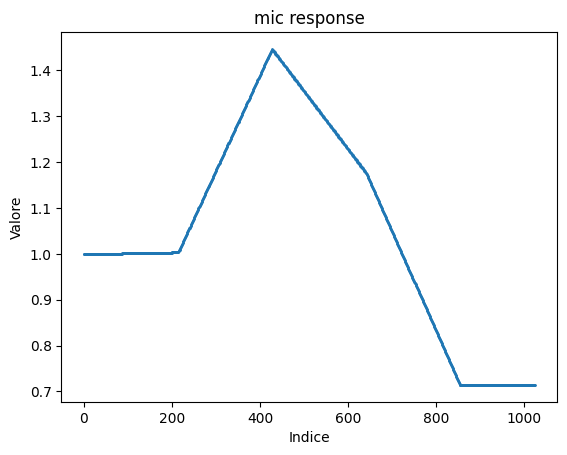

[-4.86346167e-10 -1.61090190e-10  1.89251200e-10 ...  2.95808026e-18
  1.17280798e-18 -1.26610054e-18]


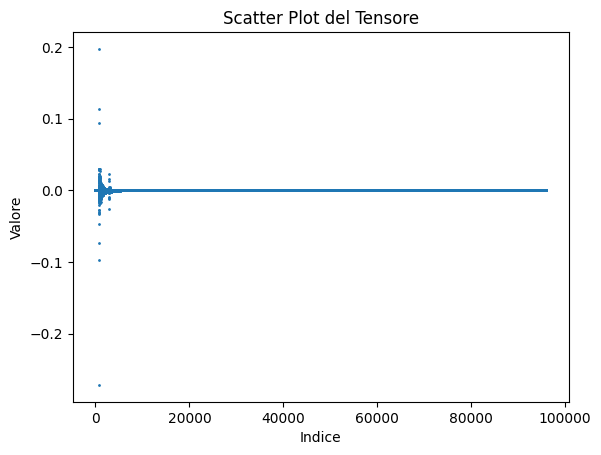

In [8]:
R_0.mic_180_loss = {1000: 0, 5000:2, 10000: 5, 15000:10, 20000:15 }

R_0.mic_0_gain = {1000: 1, 5000: 1.09, 10000: 1.78, 15000: 1.78, 20000: 1.33}
#R_0.mic_180_loss = {1000: 0, 2000:0, 4000: 0, 6000:0, 16000:0, 20000:0 }
R_0.mic_direction = torch.Tensor([0,1,0])#####################

r = R_0.render_early_microphone_response(L_0)

# Converti in NumPy
r_numpy = r.detach().numpy()
print(r_numpy)
plt.scatter(range(len(r_numpy)), r_numpy, s=1)  # Usa piccoli punti
plt.title("Scatter Plot del Tensore")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.show()

In [ ]:
R_0.mic_180_loss = {1000: 0, 2000:0.05, 4000: 0.12, 6000:0.15, 16000:0.3, 20000:0.5 }

R_0.mic_0_gain = {1000: 1, 2000: 1, 4000: 0.9, 6000: 0.87, 16000: 1.07, 20000: 1.48}
#R_0.mic_180_loss = {1000: 0, 2000:0, 4000: 0, 6000:0, 16000:0, 20000:0 }
R_0.mic_direction = torch.Tensor([0,1,0])#####################

a = timeit.timeit(lambda:R_0.render_early_microphone_response(L_0), number=5)


print ("Elapsed:", a)

[0.87675943 0.87675943 0.87675943 ... 0.61194282 0.61194282 0.61194282]


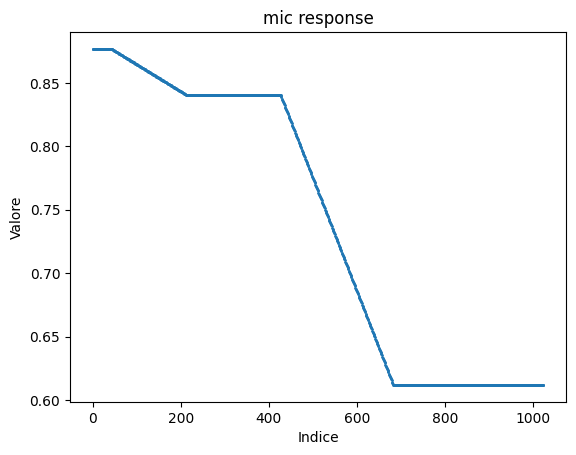

[-5.37676878e-10 -6.03394037e-10 -4.33219198e-10 ...  2.66350409e-18
  1.51594173e-18 -5.98536646e-19]


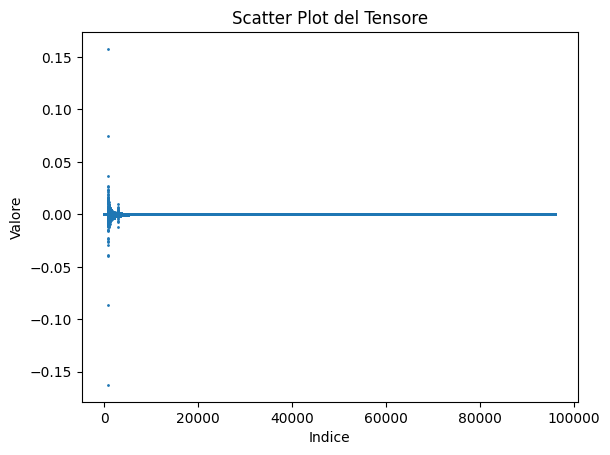

In [8]:
R_0.cardioid_exponents = {1000:0.3, 5000:0.4, 10000:0.4, 16000:1.2}

R_0.mic_0_gain = {1000: 1,  5000: 1, 10000: 1, 16000: 1}
#R_0.mic_180_loss = {1000: 0, 2000:0, 4000: 0, 6000:0, 16000:0, 20000:0 }
R_0.mic_direction = torch.Tensor([0,1,0])#####################

r = R_0.render_early_cardioid(L_0)

# Converti in NumPy
r_numpy = r.detach().numpy()
print(r_numpy)
plt.scatter(range(len(r_numpy)), r_numpy, s=1)  # Usa piccoli punti
plt.title("Scatter Plot del Tensore")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.show()

In [ ]:
R_0.cardioid_exponents = {1000:0.3, 5000:0.4, 10000:0.4, 16000:1.2}

R_0.mic_0_gain = {1000: 1,  5000: 1, 10000: 1, 16000: 1}
#R_0.mic_180_loss = {1000: 0, 2000:0, 4000: 0, 6000:0, 16000:0, 20000:0 }
R_0.mic_direction = torch.Tensor([0,1,0])#####################

a = timeit.timeit(lambda:R_0.render_early_cardioid(L_0), number=5)



print ("Elapsed:", a)

mic_response tensor([[0.9833, 0.9833, 0.9833,  ..., 0.9355, 0.9355, 0.9355],
        [0.1232, 0.1232, 0.1232,  ..., 0.0571, 0.0571, 0.0571],
        [0.9949, 0.9949, 0.9949,  ..., 0.9800, 0.9800, 0.9800],
        ...,
        [0.6146, 0.6146, 0.6146,  ..., 0.2217, 0.2217, 0.2217],
        [0.6115, 0.6115, 0.6115,  ..., 0.2191, 0.2191, 0.2191],
        [0.6124, 0.6124, 0.6124,  ..., 0.2199, 0.2199, 0.2199]])
mic_response tensor([[0.9833, 0.9833, 0.9833,  ..., 0.9355, 0.9355, 0.9355],
        [0.1232, 0.1232, 0.1232,  ..., 0.0571, 0.0571, 0.0571],
        [0.9949, 0.9949, 0.9949,  ..., 0.9800, 0.9800, 0.9800],
        ...,
        [0.6146, 0.6146, 0.6146,  ..., 0.2217, 0.2217, 0.2217],
        [0.6115, 0.6115, 0.6115,  ..., 0.2191, 0.2191, 0.2191],
        [0.6124, 0.6124, 0.6124,  ..., 0.2199, 0.2199, 0.2199]])
mic_response tensor([[0.9833, 0.9833, 0.9833,  ..., 0.9355, 0.9355, 0.9355],
        [0.1232, 0.1232, 0.1232,  ..., 0.0571, 0.0571, 0.0571],
        [0.9949, 0.9949, 0.9949,  ...

[ 1.59219263e-10  1.27047280e-10 -4.30826392e-12 ...  3.15579631e-18
  3.42373907e-18  1.64683419e-18]


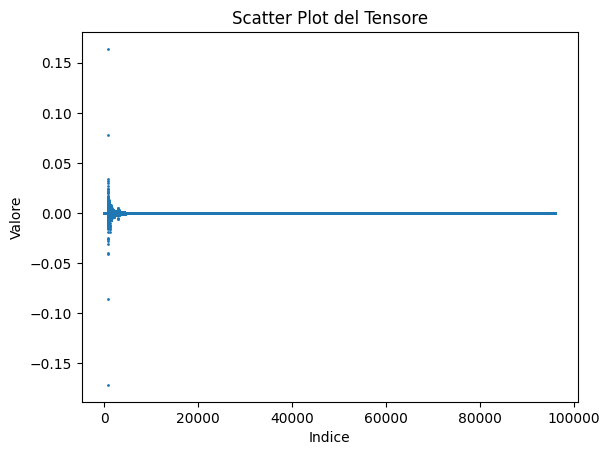

In [ ]:
r = R_0.render_early(L_0)

r_numpy = r.detach().numpy()

print(r_numpy)

plt.scatter(range(len(r_numpy)), r_numpy, s=1)  # Usa piccoli punti
plt.title("Scatter Plot del Tensore")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.show()

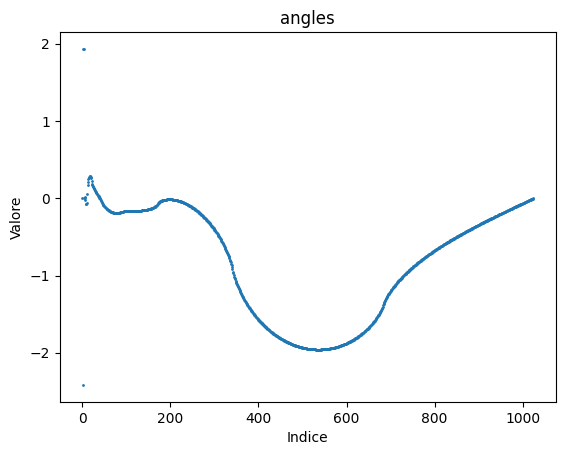

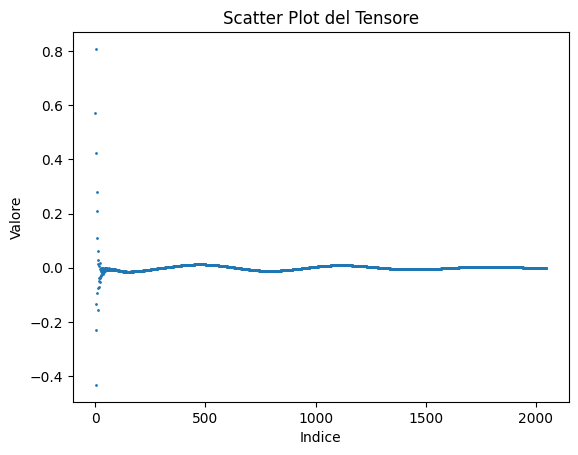

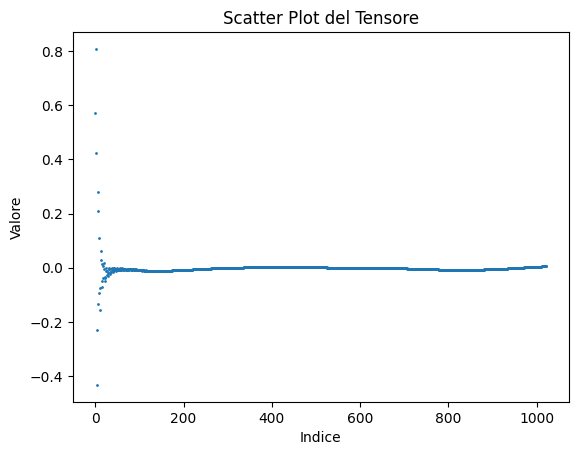

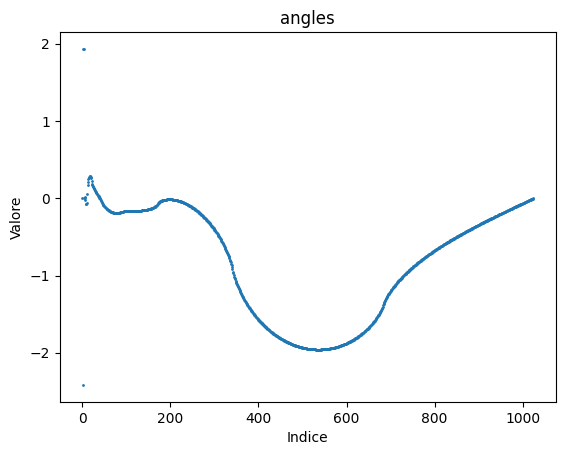

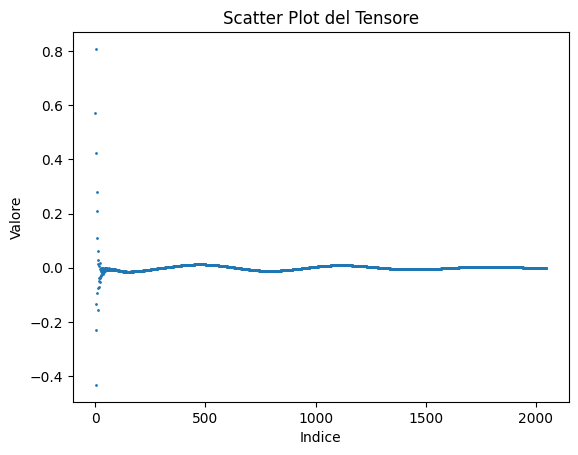

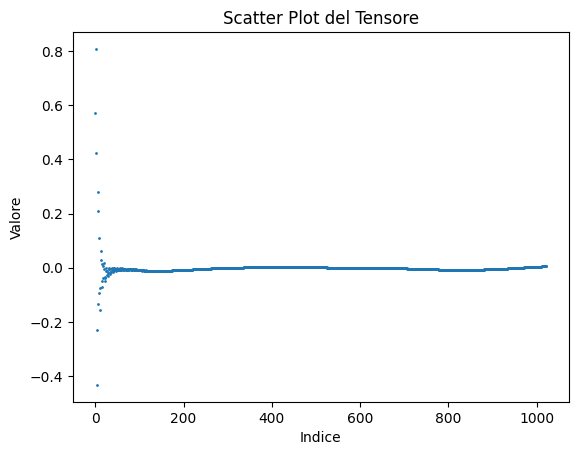

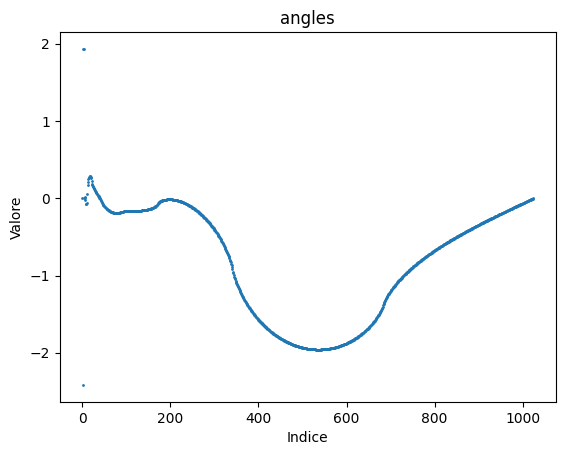

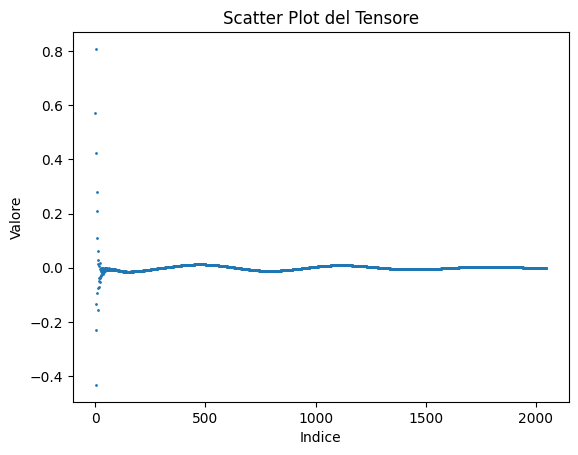

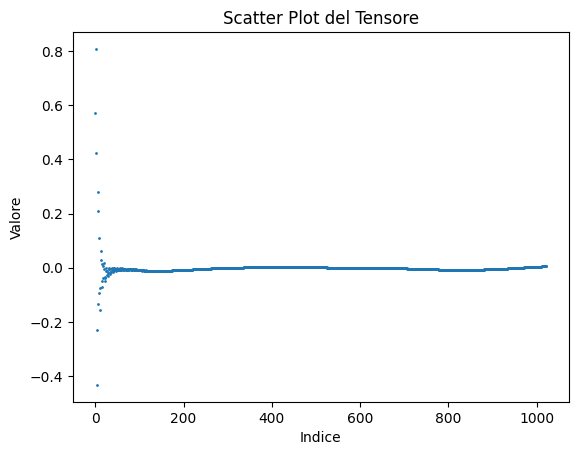

KeyboardInterrupt: 

In [ ]:
a = timeit.timeit(lambda:R_0.render_early(L_0), number=5)




print ("Elapsed:", a)

In [ ]:
import fibonacci_utilities as fib
azimuths, elevations = fib.fibonacci_azimuths_and_elevations(3)

[3.5044829e-06 3.9668384e-06 1.8009516e-05 ... 3.8816221e-13 1.7725842e-13
 9.1234962e-14]


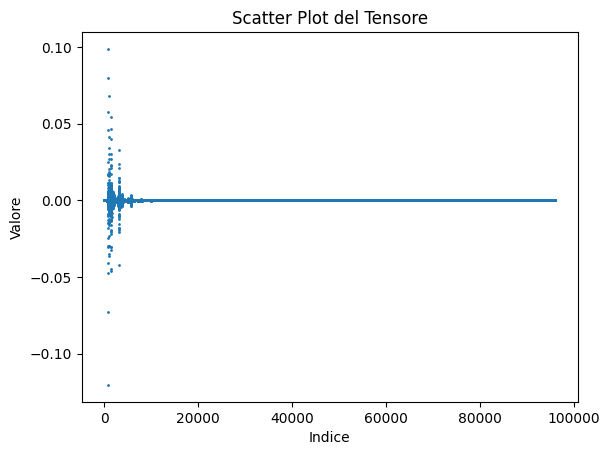

In [ ]:
r = R_0.render_early_directional(L_0, azimuths, elevations)
r

# Converti in NumPy
r_numpy = r[2]['t_response'].detach().numpy()

print(r_numpy)

plt.scatter(range(len(r_numpy)), r_numpy, s=1)  # Usa piccoli punti
plt.title("Scatter Plot del Tensore")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.show()

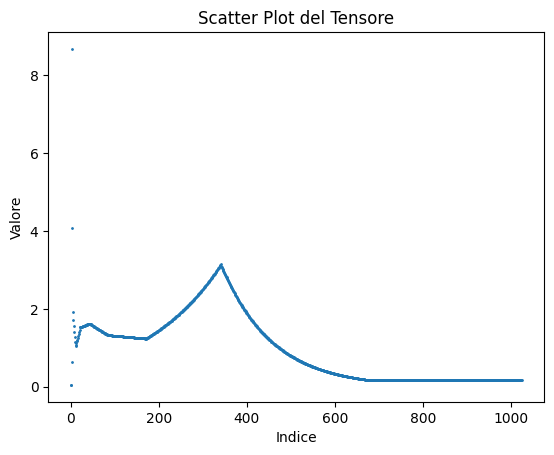

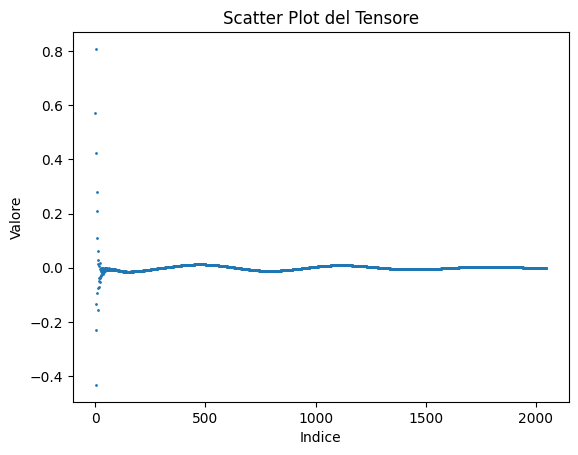

[ 2.17982599e-10  1.72373735e-10 -1.33766604e-10 ...  2.24895402e-18
  3.12509554e-18  4.20660558e-18]


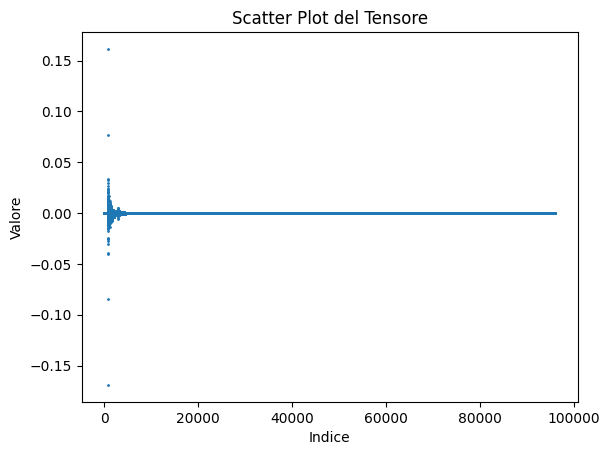

In [ ]:
r = R_0.render_early(L_0)
r

# Converti in NumPy
r_numpy = r.detach().numpy()
print(r_numpy)
plt.scatter(range(len(r_numpy)), r_numpy, s=1)  # Usa piccoli punti
plt.title("Scatter Plot del Tensore")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.show()

In [ ]:
a = timeit.timeit(lambda:R_0.render_early_directional(L_0, azimuths, elevations), number=5)

print ("Elapsed:", a)

frequency response sum: tensor(6012.1751, dtype=torch.float64, grad_fn=<SumBackward0>)
dtype [f] torch.complex64
dtype [f] torch.complex64
dtype [f] torch.complex64
frequency response sum: tensor(6012.1751, dtype=torch.float64, grad_fn=<SumBackward0>)
dtype [f] torch.complex64
dtype [f] torch.complex64
dtype [f] torch.complex64
frequency response sum: tensor(6012.1751, dtype=torch.float64, grad_fn=<SumBackward0>)
dtype [f] torch.complex64
dtype [f] torch.complex64
dtype [f] torch.complex64
frequency response sum: tensor(6012.1751, dtype=torch.float64, grad_fn=<SumBackward0>)
dtype [f] torch.complex64
dtype [f] torch.complex64
dtype [f] torch.complex64
frequency response sum: tensor(6012.1751, dtype=torch.float64, grad_fn=<SumBackward0>)
dtype [f] torch.complex64
dtype [f] torch.complex64
dtype [f] torch.complex64
Elapsed: 184.83254098500038
